# Housekeeping
First, we do some housekeeping to set up our notebook by configuring plotting settings and importing some libraries that we're going to be using. It is unlikely you would ever need to change this.

## Libraries

To the extent that you want to know what going on here. statements beginning with `import` are the Python way of telling your notebook that you plan to borrow from some Python libraries to make your life easier. Chances are, if you're doing something tedious, someone has already made a libary to make it easier to do.

You can also use abbreviateions for your libraries if you don't want tp use the whole name. For example, it's quite common to abbreviate Python matrix math library *Numpy* as simply *np* by using `import numpy as np`

## A comment about comments

Its very useful to make notes to yourself about why you did things right in the code. Whhile you can use these text cells to do complex text disply, you can also add short comments directly in the code as hints to yourself by beginning them with a `#`.



In [26]:
# Set the notebook macro to make plots look prettier
%matplotlib inline 

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

# Import the Python matrix math library Numpy, abbreviated as np
import numpy as np

# Import the Python plotting library, import the pyplot function abbreviated as plt
from matplotlib import pyplot as plt

# Import the Python data science library Pandas, abbreviated as pd
import pandas as pd

# Set the default figure size of our plt function. You can change this later.
plt.rcParams['figure.figsize'] = [12, 8]




# Let's do something interesting

We have a basic setup. Rather than doing a trivial, example to teach basics (we'll come back to that), let's dive directly into the deep end and use a library which could have been made just for us. 

Lets suppose you wanted to view an S parameter file from a vendor as plots of Sxx versus frequency. You could come up with a Python program that imports the s2p file as a CSV, converts each column to a matrix of numbers, and usees the plotting function to generate plots. But remember how I said that if you're trying to do something tedious, someone has already probably done it for you? Well even pretty in-the-weeds RF engineering has a library. And it will plot s parameter files for you.  

Lets jump in...

In [27]:
# Import the Scienctific Python SKRF library. Abbreviated as RF
import skrf as rf

#from skrf import media

# Now, import some s param files on my computer. The left side of the = is what we want to call it
# The right side of the = is the command to say we're importing a network file and a path to its location
# The first network is an S band Anaran Xinger coupler
xinger = rf.Network('/home/bah235/Documents/ATE/ATE/X3C20A2-03_SParam.s4p')
# This is the small signal params of an S band MMIC. I didn't have to type the whole path to the file
# because its in the same folder as this notebook.
TGA2976 = rf.Network('TGA2976-SM_40V_360mA.s2p')




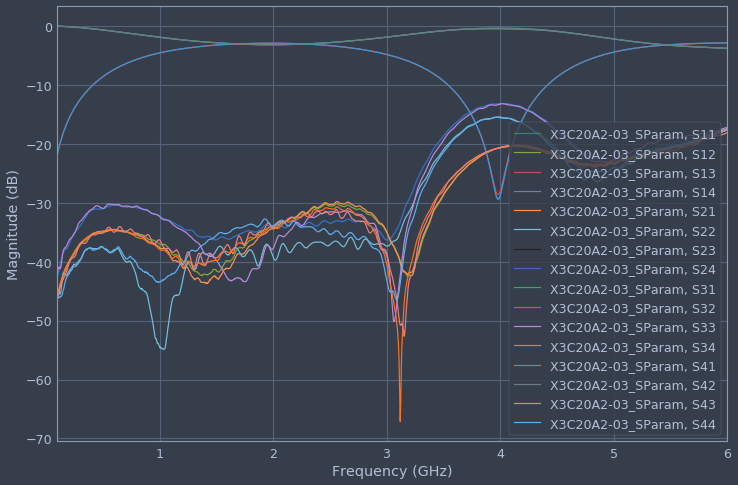

In [28]:
# Now we can refer to anything we do with the coupler's parameter file as "xinger" since thats what we called it
# Now lets go for it. Plot all s params for the device
xinger.plot_s_db()

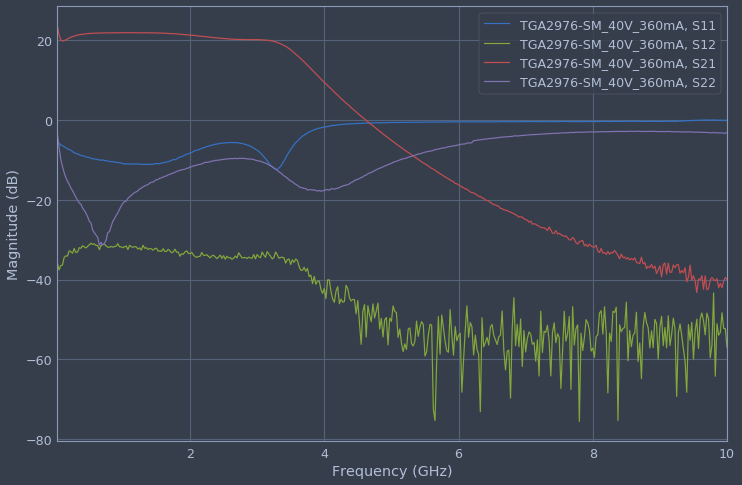

In [29]:
# Plot all s params for the device
TGA2976.plot_s_db()


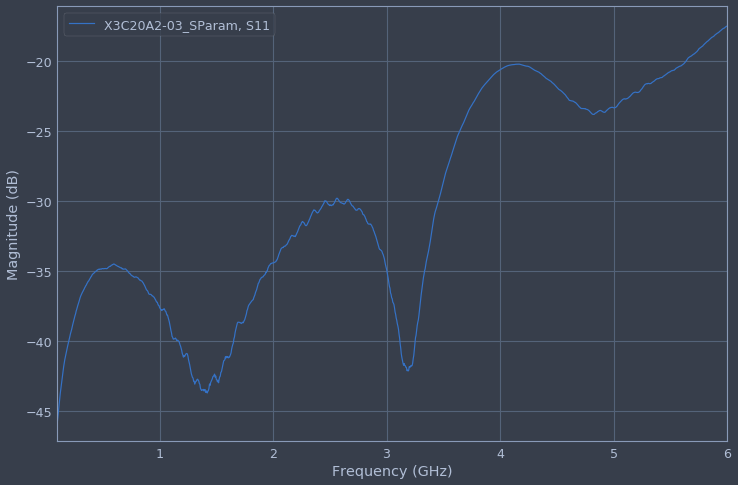

In [30]:
# Plot only one parameter
xinger.s21.plot_s_db()

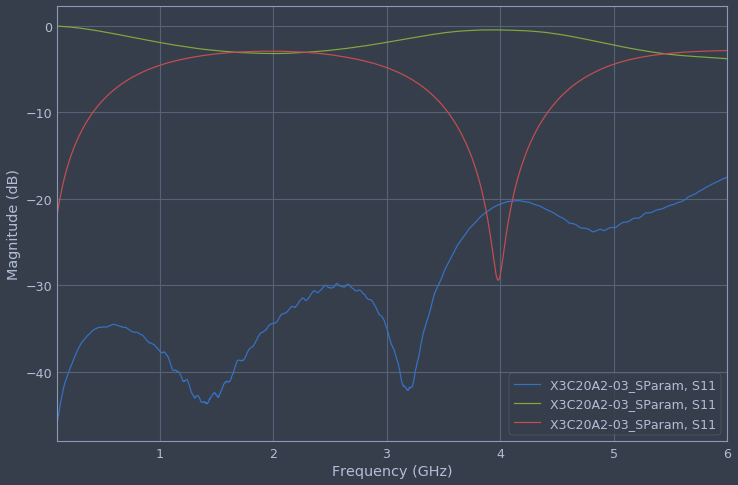

In [31]:
# What if I want to print more than one param on the same plot?
xinger.s21.plot_s_db()
xinger.s31.plot_s_db()
xinger.s41.plot_s_db()

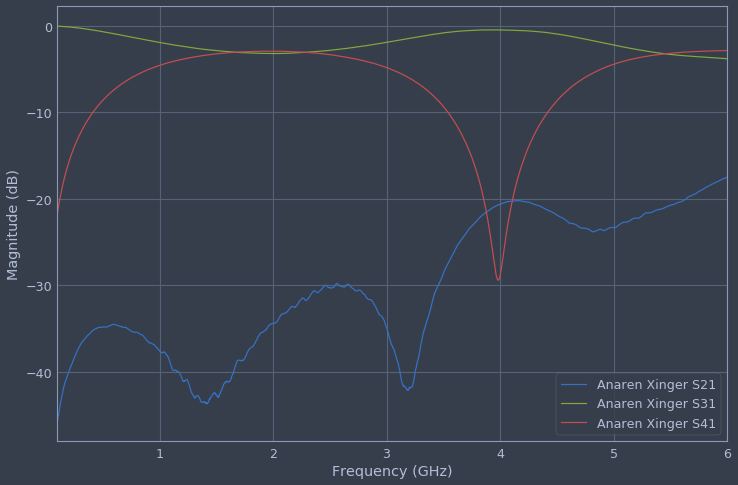

In [32]:
# You may have noticed a problem. when we print all the params, the library takes care of the labels
# if we try to print one at a time, they all get labeled S11. This is a bug. 
# we can specify the labels by adding options in our plot functions

xinger.s21.plot_s_db(label='Anaren Xinger S21')
xinger.s31.plot_s_db(label='Anaren Xinger S31')
xinger.s41.plot_s_db(label='Anaren Xinger S41')


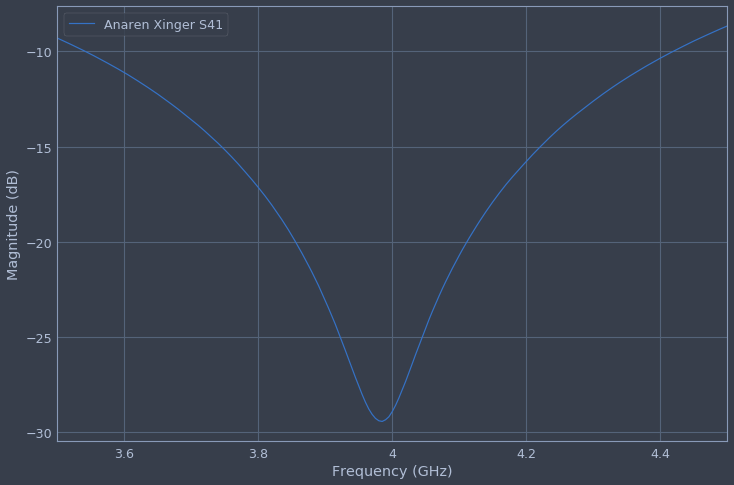

In [33]:
# You can also plot only a portion of the frequency range
xinger.s41['3.5-4.5ghz'].plot_s_db(label='Anaren Xinger S41')


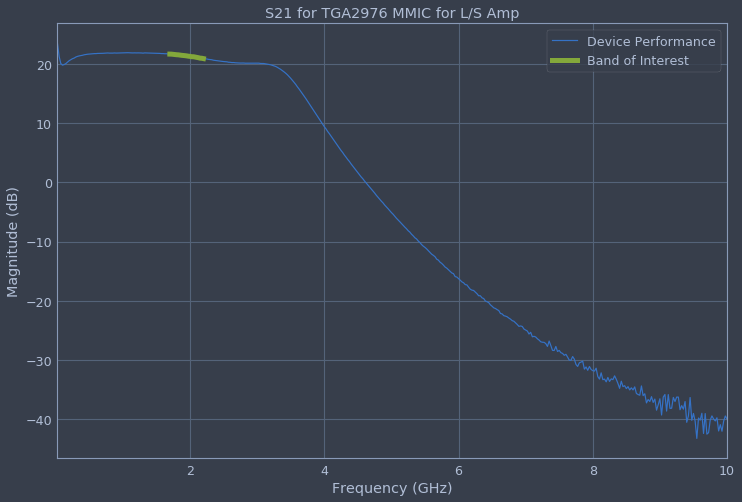

In [34]:
# Lets combine some of these ideas to make an interesting plot
TGA2976.s21.plot_s_db(label='Device Performance')
TGA2976.s21['1.7-2.2ghz'].plot_s_db(lw=5, label='Band of Interest', title="S21 for TGA2976 MMIC for L/S Amp")



First, we read in an s1p file to create a load impedance for terminating the couplers. We also plot the response as a sanity check.

1-Port Network: 'load',  0.0-10.0 GHz, 5 pts, z0=[50.+0.j]


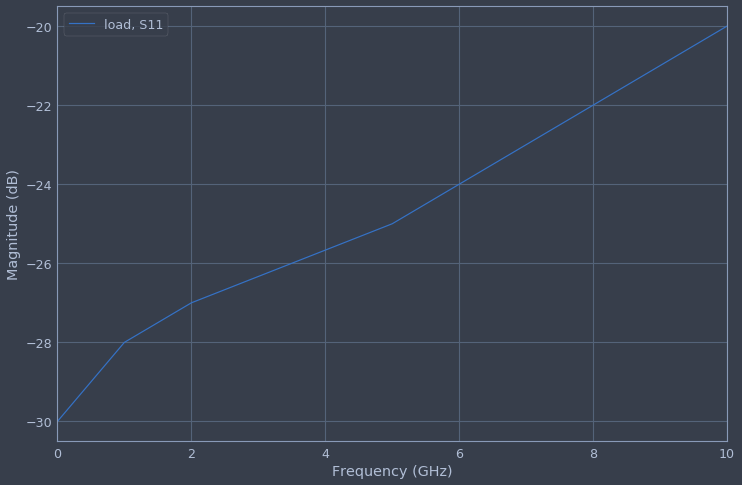

In [35]:
Load = rf.Network('load.s1p')
Load.s11.plot_s_db()
print(Load)

Next, we deal with the Xinger couplers. We make splitter and combiner objects but connecting the terminations apropriately.

Start by creating a frequency object to resample the S parameter files so they all have the same series of frequency points.

Then connect terminations to the couplers on port 2 to form a splitter and port 4 to form a combiner.


In [36]:
#Create Frequency Definition
freq = rf.Frequency(1,3,201,'ghz')

Load = Load.interpolate_from_f(freq)
print("The termination: ", Load)

coupler = xinger['1-3ghz']
coupler.resample(201)
print("The 4 port Xinger Coupler: ", coupler)

Splitter = coupler
Combiner = coupler

Splitter = rf.connect(Splitter, 1, Load, 0)
Combiner = rf.connect(Combiner, 3, Load, 0)

print("The 3 port Splitter: ", Splitter)
print("The 3 port Combiner: ", Combiner)


The termination:  1-Port Network: 'load',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j]
The 4 port Xinger Coupler:  4-Port Network: 'X3C20A2-03_SParam',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]
The 3 port Splitter:  3-Port Network: 'X3C20A2-03_SParam',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j 50.+0.j]
The 3 port Combiner:  3-Port Network: 'X3C20A2-03_SParam',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j 50.+0.j]


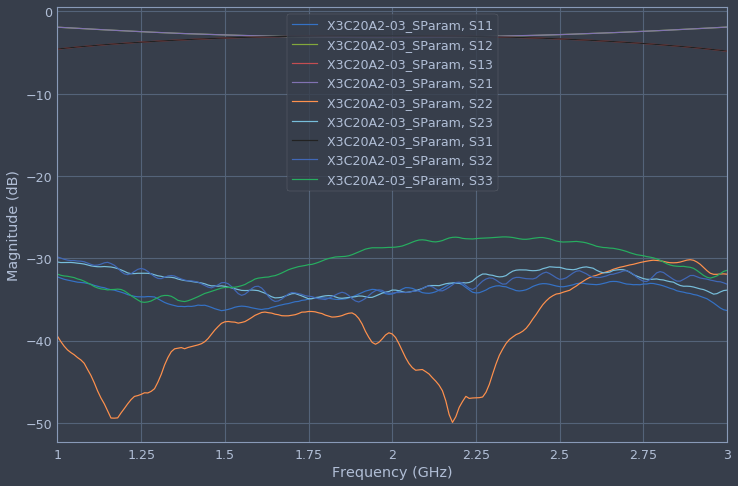

In [37]:
Splitter.plot_s_db()

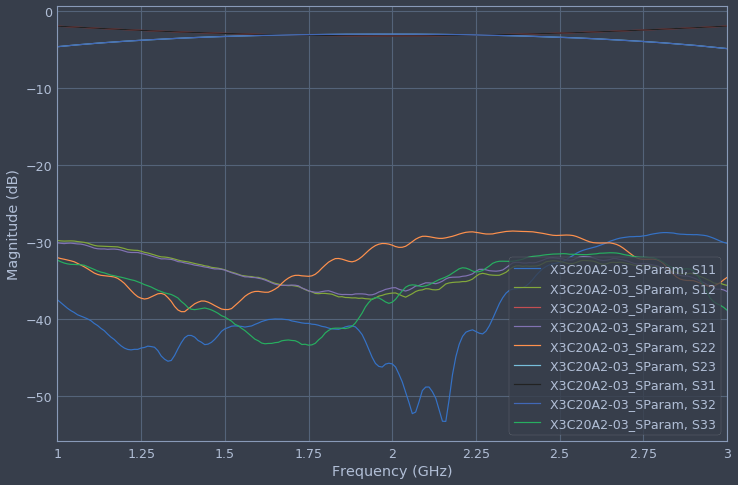

In [38]:
Combiner.plot_s_db()

Create amplifier objects and resample the S parameter data to matching frequency indicies.

I Branch Amp 2-Port Network: 'TGA2976-SM_40V_360mA',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]
Q Branch Amp 2-Port Network: 'TGA2976-SM_40V_360mA',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]
The new cascade:  3-Port Network: 'X3C20A2-03_SParam',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j 50.+0.j]


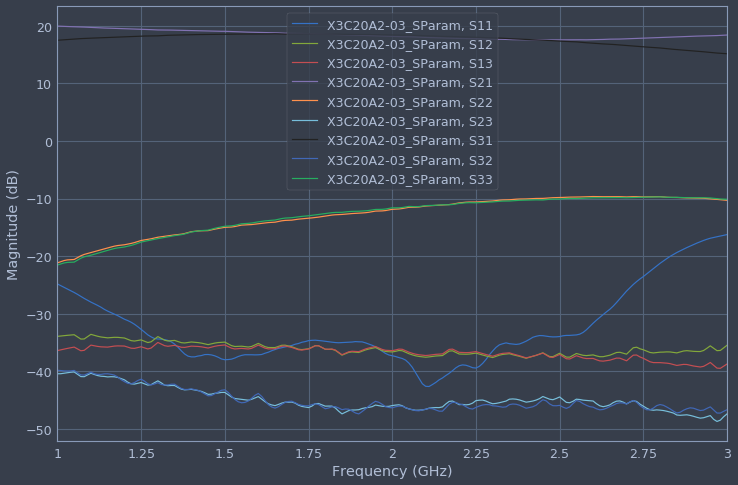

In [39]:
amp = TGA2976['1-3ghz']
amp.resample(201)
amp1 = amp
amp2 = amp
print("I Branch Amp", amp1)
print("Q Branch Amp", amp2)

# Connect the amps tp the splitter with the connect command
# Remember that port indicies are numbered from 0 and not one for these operations
cascade = rf.connect(Splitter, 1, amp1, 0)
cascade = rf.connect(cascade, 2, amp2, 0)

print("The new cascade: ", cascade)

cascade.plot_s_db()
axis = plt.gca()
#axis.set(ylim=(15, 20))

Comment: 

Remember to label the cells when plotting specific S parameters. The automatic labelling only works when you plot all the s terms. This is a bit of a bug.


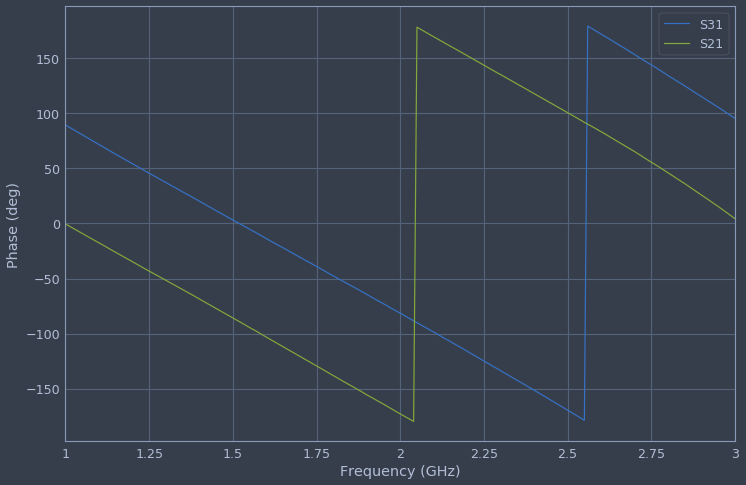

In [40]:
cascade.s31.plot_s_deg(label='S31')
cascade.s21.plot_s_deg(label='S21')

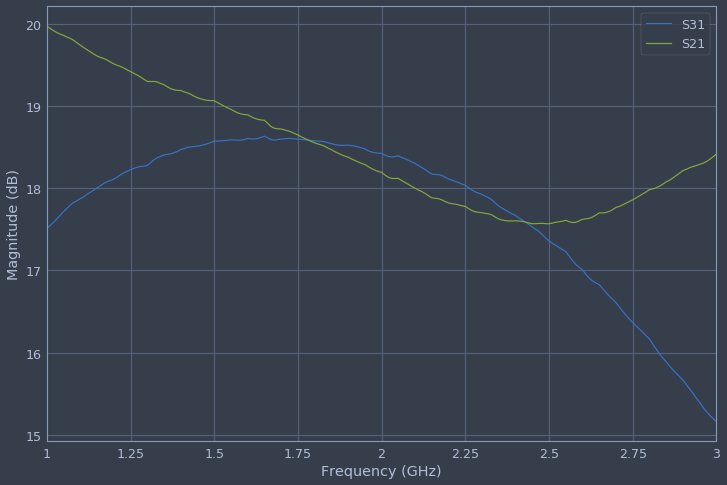

In [41]:
cascade.s31.plot_s_db(label='S31')
cascade.s21.plot_s_db(label='S21')

3-Port Network: 'X3C20A2-03_SParam',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j 50.+0.j]
3-Port Network: 'X3C20A2-03_SParam',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j 50.+0.j]
2-Port Network: 'X3C20A2-03_SParam',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]


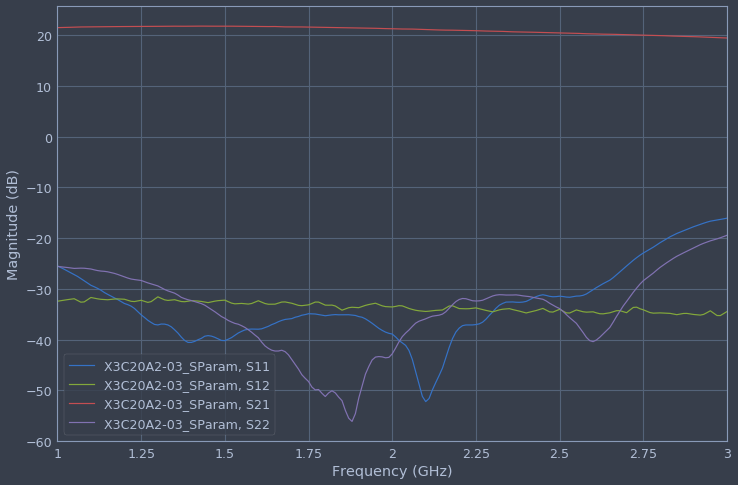

In [42]:
print(cascade)
print(Combiner)

Combiner.renumber([0,1,2],[1,0,2])

# Connect first branch to combiner.
final = rf.connect(cascade, 1, Combiner, 0,2)
print(final)
final.plot_s_db()
# Now we have a problem, because it's just one network. Not we need to use the self connect
# cascade.s31.plot_s_db(label='S31')
# cascade.s21.plot_s_db(label='S21')
# cascade.s41.plot_s_db(label='S41')

Now, we take two of these networks and combine them again.

In [43]:
top = final
bottom = final

print(top)
print(bottom)

2-Port Network: 'X3C20A2-03_SParam',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]
2-Port Network: 'X3C20A2-03_SParam',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]


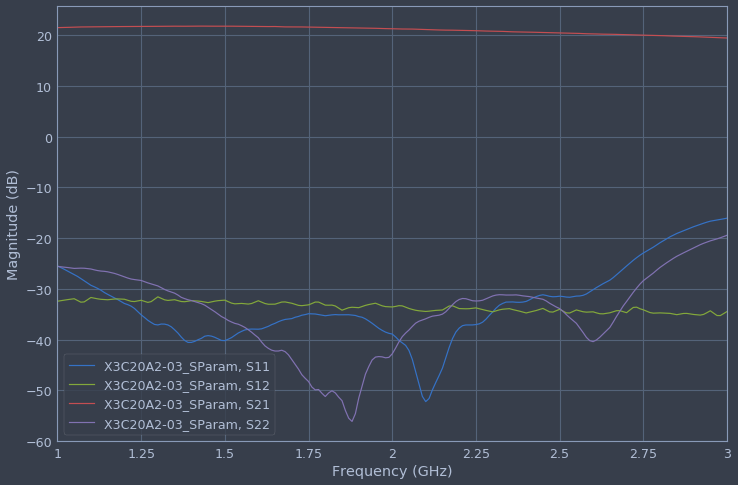

In [44]:
top.plot_s_db()

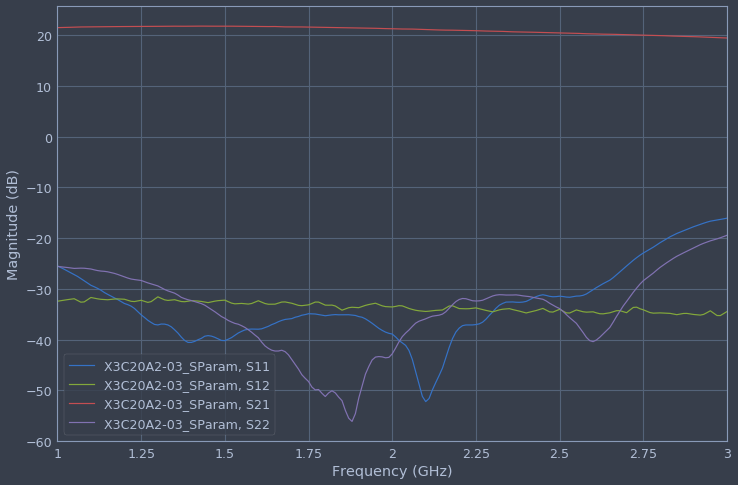

In [45]:
bottom.plot_s_db()

2-Port Network: 'X3C20A2-03_SParam',  1.0-3.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]


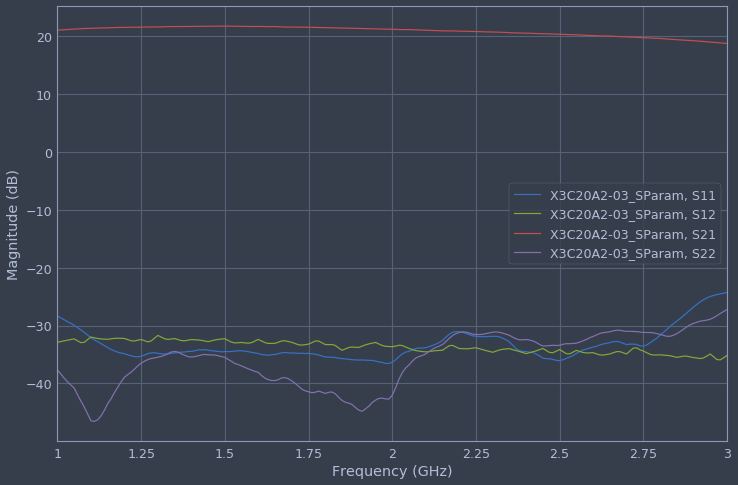

In [46]:
postamp = rf.connect(Splitter, 1, top, 0)
postamp = rf.connect(postamp, 2, bottom, 0)
postamp = rf.connect(postamp, 1, Combiner, 0,2)
print(postamp)
postamp.plot_s_db()